# Seasonal change of CDHs
    
Written by Gesangyangji; last updated Dec 12, 2020 <br>


In [1]:
import matplotlib                   
import matplotlib.pyplot as plt 
from matplotlib import cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import numpy as np                  
import pandas as pd 
import math
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings

from loadingdata import getvarsfordecades
from loadingdata import csv2dict


In [2]:
warnings.filterwarnings("ignore")

## Step 1: loading data for target variables

In [3]:
yrstr = ['2011_2030','2021_2040','2031_2050','2041_2060','2051_2070','2061_2080','2071_2090','2081_2100']; 
CityLname = ['MADISON','CHICAGO','ATLANTA','BOSTON', 'DALLAS', 'MIAMI', 'HOUSTON','NASHVILLE','OMAHA', 
             'STLOUIS', 'COLUMBUS','MINNEAPOLIS','NEWYORK', 'RALEIGH', 'WASHINGTONDC'] 
CitySname = ['MSN','MDW','ATL','BOS','DFW','MIA','IAH','BNA','OMA',
             'STL','CMH','MSP','JFK','RDU','IAD']

In [4]:
# check what vars are in the file
rawdata = csv2dict('MADISON', '2011_2030', 'rcp45') # data for different cities, scens,decades are in the same format
rawdata.keys()

dict_keys(['m', 'db1', 'db2', 'ws1', 'mdb1', 'ws2', 'mdb2', 'mws1', 'mwd1', 'x', 'mrange', 'mws3', 'mwd3', 'db', 'mcwb', 'wb', 'mcdb', 'extreme_max_wb', 'dp', 'hr', 'mcdb_dp', 'enthalpy', 'mcdb_enth', 'extreme_ws', 'mean_min', 'mean_max', 'sd_min', 'sd_max', 'T_n_min', 'T_n_max', 'Annual_Tavg', 'Tavg', 'Sd', 'Annual_HDD_10', 'HDD_10', 'Annual_HDD_183', 'HDD_183', 'Annual_CDD_10', 'CDD_10', 'Annual_CDD_183', 'CDD_183', 'Annual_CDH_233', 'CDH_233', 'Annual_CDH_267', 'CDH_267', 'M_DB_Range', 'Monthly_DB_db', 'Monthly_DB_wb', 'Monthly_WB_db', 'Monthly_WB_wb', 'mo_db_04', 'mo_mcwb_04', 'mo_db_2', 'mo_mcwb_2', 'mo_db_5', 'mo_mcwb_5', 'mo_db_10', 'mo_mcwb_10', 'mo_wb_04', 'mo_mcdb_04', 'mo_wb_2', 'mo_mcdb_2', 'mo_wb_5', 'mo_mcdb_5', 'mo_wb_10', 'mo_mcdb_10', 'hours8_4'])

## Step 2: calculate seasonal change:   
e.g.(spring2090-spring2020)/spring2020

1) select data for present, mid-, late- century

In [5]:
raw_df1 = getvarsfordecades(CityLname,yrstr,'CDH_233','rcp85')
raw_df2 = getvarsfordecades(CityLname,yrstr,'CDH_267','rcp85')
# raw_df1
data1 = raw_df1[['city','lat','lon','2011_2030','2041_2060','2081_2100']]
data2 = raw_df2[['city','lat','lon','2011_2030','2041_2060','2081_2100']]
# data2['test']=np.arange(15)
data2.head()

,city,lat,lon,2011_2030,2041_2060,2081_2100
0,MADISON,43.14N,89.35W,"[0.000000, 0.000000, 0.357685, 10.952833, ...","[0.000000, 0.000000, 2.852627, 31.966624, ...","[0.000000, 0.030663, 15.613699, 123.592158,..."
1,MINNEAPOLIS,44.88N,93.23W,"[0.000000, 0.000000, 0.504769, 13.252408, ...","[0.000000, 0.000000, 1.931613, 30.241414, ...","[0.000000, 0.007668, 8.159982, 99.017290, ..."
2,WASHINGTONDC,38.94N,77.45W,"[0.000000, 0.039399, 11.058803, 65.462943, ...","[0.000000, 0.242615, 25.136000, 138.267734,...","[0.202422, 1.232368, 64.979068, 340.744520,..."
3,MIAMI,25.82N,80.3W,"[80.163685, 122.706458, 244.553299, 451.726...","[369.603647, 459.933413, 766.553696, 1089.1...","[1625.821494, 1671.990503, 2325.662119, 283..."
4,COLUMBUS,39.99N,82.88W,"[0.000000, 0.000088, 2.136677, 26.138626, ...","[0.000000, 0.130726, 11.860319, 81.316402, ...","[0.214207, 1.164404, 49.462493, 273.041282,..."


2) get seasonal data for each decade each city

In [12]:
# some functions 
def str2num_latlon(oldlist):
    newlist = []
    for val in oldlist:
        newlist.append(float(val[:-1]))
    return newlist

def str2num(li):
    newlist = []
    for val in li:
        newlist.append(int(round(float(val),0))) 
    return newlist

def get_seasonaldata(data):
    mon_data=data
    mon_data2 = str2num(mon_data)
    li1 = mon_data2[2:]
    li2 = mon_data2[:2]
    new_li = li1+li2

    n=3 # 3 months per seasons
    list2 = [sum(new_li[i:i+n])//n for i in range(0,len(new_li),n)]
    return list2

def perctchange(list1,list2):
    changelst = []
    for i in range(len(list1)):
        if (list1[i]==0)&(list2[i]==0): # there is no change 
            perc_diff=0
        # if present value is 0 (denominator=0), then change is infinite,from 0 to some is a big change 
        elif list1[i]==0:
            perc_diff=math.inf 
        else:   
            perc_diff = (list2[i]-list1[i])/list1[i]
        changelst.append(round(perc_diff*100,2))
    return changelst 

def orderby_lat(df):
    df['orderbylat']=str2num_latlon(df['lat'])
    df.sort_values(by=['orderbylat'],ascending=False,inplace=True)
    df.drop(['orderbylat'],axis=1,inplace=True)
    return df

In [14]:
# order data through northern cities to southern cities 
data1=orderby_lat(data1)
data2=orderby_lat(data2)
data2

,city,lat,lon,2011_2030,2041_2060,2081_2100
1,MINNEAPOLIS,44.88N,93.23W,"[0.000000, 0.000000, 0.504769, 13.252408, ...","[0.000000, 0.000000, 1.931613, 30.241414, ...","[0.000000, 0.007668, 8.159982, 99.017290, ..."
0,MADISON,43.14N,89.35W,"[0.000000, 0.000000, 0.357685, 10.952833, ...","[0.000000, 0.000000, 2.852627, 31.966624, ...","[0.000000, 0.030663, 15.613699, 123.592158,..."
9,BOSTON,42.36N,71.01W,"[0.000000, 0.000000, 1.749737, 18.863346, ...","[0.000000, 0.000000, 3.847141, 33.476898, ...","[0.006135, 0.070815, 12.080133, 80.907869, ..."
14,CHICAGO,41.79N,87.75W,"[0.000000, 0.000000, 2.141154, 28.716908, ...","[0.000000, 0.029157, 8.131463, 69.850256, ...","[0.017808, 0.406154, 35.430809, 222.298261,..."
11,OMAHA,41.31N,95.9W,"[0.000000, 0.010094, 5.113640, 64.696626, ...","[0.000353, 0.175858, 15.987055, 126.328874,...","[0.402099, 2.375548, 55.982660, 300.930177,..."
10,NEWYORK,40.66N,73.8W,"[0.000000, 0.000000, 0.598000, 5.386770, 5...","[0.000000, 0.000000, 1.662198, 12.122828, ...","[0.016696, 0.037195, 5.334580, 38.484100, ..."
4,COLUMBUS,39.99N,82.88W,"[0.000000, 0.000088, 2.136677, 26.138626, ...","[0.000000, 0.130726, 11.860319, 81.316402, ...","[0.214207, 1.164404, 49.462493, 273.041282,..."
2,WASHINGTONDC,38.94N,77.45W,"[0.000000, 0.039399, 11.058803, 65.462943, ...","[0.000000, 0.242615, 25.136000, 138.267734,...","[0.202422, 1.232368, 64.979068, 340.744520,..."
5,STLOUIS,38.75N,90.37W,"[0.006471, 0.124850, 10.181084, 87.884935, ...","[0.101456, 1.052209, 33.832937, 194.408383,...","[4.220163, 7.647137, 113.197175, 506.133645..."
7,NASHVILLE,36.12N,86.69W,"[0.000000, 0.264546, 8.774815, 89.155934, ...","[0.018054, 1.066567, 36.008443, 214.269833,...","[2.688534, 8.381820, 139.049106, 596.707520..."


In [15]:
season1_2020 = []
season1_2050 = []
season1_2090 = []
season2_2020 = []
season2_2050 = []
season2_2090 = []

for icity in range(len(CityLname)):
    # cdh23.3
    mon_data1 = data1['2011_2030'][icity]    
    season1_2020.append(get_seasonaldata(mon_data1)) 
    mon_data1 = data1['2081_2100'][icity]    
    season1_2090.append(get_seasonaldata(mon_data1)) 
    
    # cdh26.7
    mon_data2 = data2['2011_2030'][icity]    
    season2_2020.append(get_seasonaldata(mon_data2)) 
    mon_data2 = data2['2081_2100'][icity]    
    season2_2090.append(get_seasonaldata(mon_data2)) 

3) get percentage change from present(2020) to future (herein 2090 under rcp 8.5)

In [16]:
seasonchange1_by50 = []
seasonchange1_by90 = []
seasonchange2_by50 = []
seasonchange2_by90 = []

for icity in range(len(CityLname)):
    seasonchange1_by90.append(perctchange(season1_2020[icity],season1_2090[icity]))
    seasonchange2_by90.append(perctchange(season2_2020[icity],season2_2090[icity]))

In [17]:
# add to the df for plotting 
data1['MAM_20_90']=''
data1['JJA_20_90']=''
data1['SON_20_90']=''
data1['DJF_20_90']=''
data2['MAM_20_90']=''
data2['JJA_20_90']=''
data2['SON_20_90']=''
data2['DJF_20_90']=''

for icity in range(len(CityLname)):
    # cdh23.3
    data1['MAM_20_90'][icity] = seasonchange1_by90[icity][0]
    data1['JJA_20_90'][icity] = seasonchange1_by90[icity][1]
    data1['SON_20_90'][icity] = seasonchange1_by90[icity][2]
    data1['DJF_20_90'][icity] = seasonchange1_by90[icity][3]
    # cdh26.7
    data2['MAM_20_90'][icity] = seasonchange2_by90[icity][0]
    data2['JJA_20_90'][icity] = seasonchange2_by90[icity][1]
    data2['SON_20_90'][icity] = seasonchange2_by90[icity][2]
    data2['DJF_20_90'][icity] = seasonchange2_by90[icity][3]

data2.head()

,city,lat,lon,2011_2030,2041_2060,2081_2100,MAM_20_90,JJA_20_90,SON_20_90,DJF_20_90
1,MINNEAPOLIS,44.88N,93.23W,"[0.000000, 0.000000, 3.332608, 52.275440, ...","[0.000000, 0.001104, 9.109562, 106.617505, ...","[0.000433, 0.127347, 28.449001, 281.801103,...",303.01,177.54,336.56,0
0,MADISON,43.14N,89.35W,"[0.000000, 0.000000, 5.270354, 54.966712, ...","[0.000000, 0.003504, 16.023304, 116.701737,...","[0.000126, 0.350775, 51.245236, 327.353979,...",366.94,186.49,357.71,0
9,BOSTON,42.36N,71.01W,"[0.002270, 0.000000, 6.801591, 50.085552, ...","[0.042761, 0.042105, 14.506816, 84.145116, ...","[0.761094, 1.252817, 36.374007, 187.118154,...",292.71,233.83,552.53,inf
14,CHICAGO,41.79N,87.75W,"[0.000000, 0.064904, 14.574453, 106.267304,...","[0.007343, 0.479307, 38.771798, 211.207052,...","[1.043232, 2.527132, 106.579660, 518.060543...",308,156.2,297.25,inf
11,OMAHA,41.31N,95.9W,"[0.005749, 0.386597, 29.147287, 191.508403,...","[0.141243, 1.742815, 61.725114, 329.747311,...","[3.203193, 11.758492, 156.176265, 665.39733...",226.74,128.95,240.27,inf


## Step 3: plot 

In [18]:
dplot1_85 = data1[['city','MAM_20_90','JJA_20_90','SON_20_90','DJF_20_90']]
dplot2_85 = data2[['city','MAM_20_90','JJA_20_90','SON_20_90','DJF_20_90']]
dplot1_85.head()

,city,MAM_20_90,JJA_20_90,SON_20_90,DJF_20_90
1,MINNEAPOLIS,303.01,177.54,336.56,0
0,MADISON,366.94,186.49,357.71,0
9,BOSTON,292.71,233.83,552.53,inf
14,CHICAGO,308,156.2,297.25,inf
11,OMAHA,226.74,128.95,240.27,inf


<font color=blue>Note<font/>: Can not plot inf, so assume 0-some is equal to the max of the seasom (winter).

##################For CDH 23.3

In [19]:
dropinf=dplot1_85[dplot1_85['DJF_20_90']!=math.inf]
np.max(dropinf['DJF_20_90'])
newdplot1_85=dplot1_85
newdplot1_85['DJF_20_90'].replace(to_replace =math.inf,value =np.max(dropinf['DJF_20_90']),inplace=True)
newdplot1_85.set_index('city',inplace=True)
newdplot1_85.index.name = None
newdplot1_85

,MAM_20_90,JJA_20_90,SON_20_90,DJF_20_90
MINNEAPOLIS,303.01,177.54,336.56,0.00
MADISON,366.94,186.49,357.71,0.00
BOSTON,292.71,233.83,552.53,4200.00
CHICAGO,308,156.2,297.25,4200.00
OMAHA,226.74,128.95,240.27,4200.00
NEWYORK,338.89,208.42,526.7,4200.00
COLUMBUS,290,149.92,309.9,4200.00
WASHINGTONDC,224.09,148.4,300.51,4200.00
STLOUIS,229.78,100.76,219.44,2900.00
NASHVILLE,227.25,100.81,219.17,4200.00


<Figure size 1080x576 with 0 Axes>

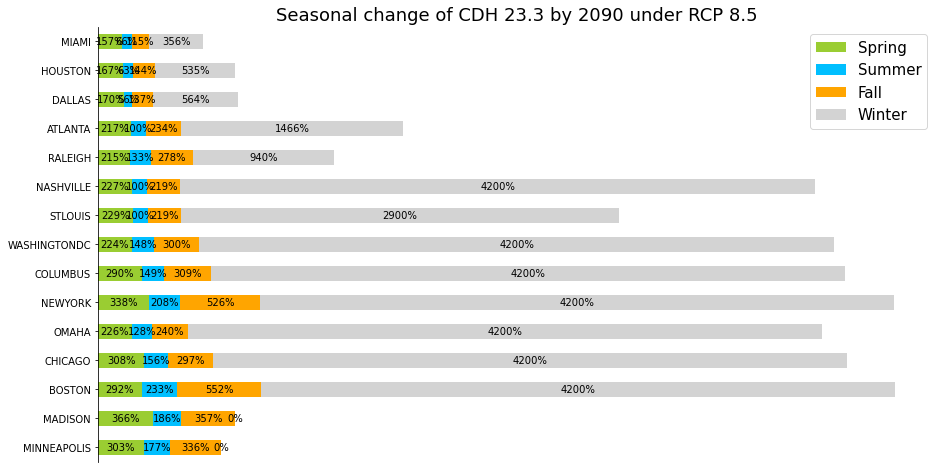

In [20]:
plt.figure(figsize=(15,8))
colors = ['yellowgreen','deepskyblue','orange','lightgray']

ax = newdplot1_85.plot.barh(figsize=(15,8),stacked=True,color=colors)
ax.legend(["Spring",'Summer','Fall','Winter'],fontsize=15)
ax.set_xticks([])


plt.title('Seasonal change of CDH 23.3 by 2090 under RCP 8.5',fontsize=18)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

for n in newdplot1_85: 
    for i, (cs, ab) in enumerate(zip(newdplot1_85.iloc[:, 0:].cumsum(1)[n],newdplot1_85[n])): 
        plt.text(cs-ab/2,i,str(int(ab))+'%',va='center',ha='center',color='black',fontsize=10)

# plt.savefig('results_plot/seasonalchange_cdh267_by2090_85.png',bbox_inches='tight')

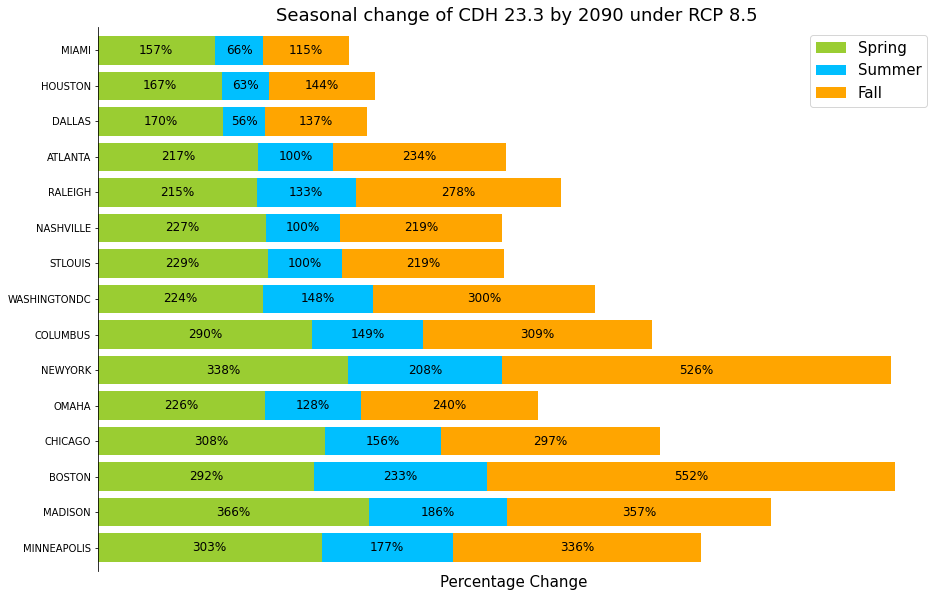

In [24]:
# when remove winter 
df=newdplot1_85.drop(['DJF_20_90'],axis=1)
colors = ['yellowgreen','deepskyblue','orange','lightgray']

ax=df.plot.barh(figsize=(15,10),stacked=True,color=colors,width=0.8)
ax.legend(["Spring",'Summer','Fall'],fontsize=15)
ax.set_xlabel("Percentage Change ",fontsize=15)
ax.set_xticks([])

# ax.set_ylabel()
# ticks=[150,300,450,600,750,900,1050]
# ax.set_xticks(ticks)
# xlabel = [str(int(np.round(it,0)))+"%" for it in ticks]
# ax.set_xticklabels(xlabel,fontsize=14)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)


for n in df: 
    for i, (cs, ab) in enumerate(zip(df.iloc[:, 0:].cumsum(1)[n],df[n])): 
        plt.text(cs-ab/2,i,str(int(ab))+'%',va='center',ha='center',color='black',fontsize=12)


plt.title('Seasonal change of CDH 23.3 by 2090 under RCP 8.5',fontsize=18)
plt.savefig('results_plot/seasonalchange_cdh233_by2090_85.png',bbox_inches='tight')


##################For CDH 23.3

In [123]:
dropinf=dplot2_85[dplot2_85['DJF_20_90']!=math.inf]
np.max(dropinf['DJF_20_90'])
newdplot2_85=dplot2_85
newdplot2_85['DJF_20_90'].replace(to_replace =math.inf,value =np.max(dropinf['DJF_20_90']),inplace=True)
newdplot2_85.set_index('city',inplace=True)
newdplot2_85.index.name = None
newdplot2_85

,MAM_20_90,JJA_20_90,SON_20_90,DJF_20_90
MADISON,703.33,332.96,678.26,0.00
MINNEAPOLIS,447.62,305.79,588.89,0.00
WASHINGTONDC,348.04,242.58,509.09,1962.50
MIAMI,416.03,140.5,281.38,1561.11
COLUMBUS,521.88,256.78,532.97,0.00
STLOUIS,405.56,169.62,352.4,1962.50
RALEIGH,379.87,218.68,485.64,1962.50
NASHVILLE,429.85,165.42,351.91,1962.50
ATLANTA,406.8,166.2,411.76,1962.50
BOSTON,406.06,409.36,1000,0.00


<Figure size 1080x576 with 0 Axes>

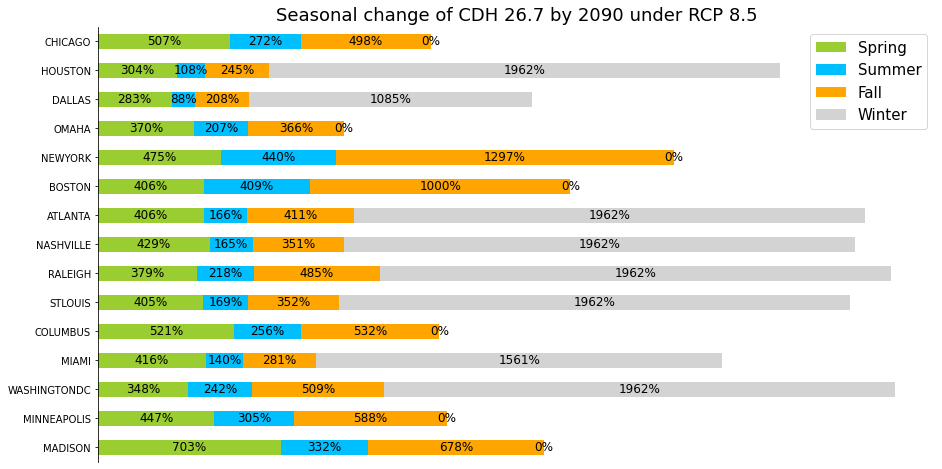

In [133]:
plt.figure(figsize=(15,8))
colors = ['yellowgreen','deepskyblue','orange','lightgray']

ax = newdplot2_85.plot.barh(figsize=(15,8),stacked=True,color=colors)
ax.legend(["Spring",'Summer','Fall','Winter'],fontsize=15)
ax.set_xticks([])

plt.title('Seasonal change of CDH 26.7 by 2090 under RCP 8.5',fontsize=18)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

for n in newdplot2_85: 
    for i, (cs, ab) in enumerate(zip(newdplot2_85.iloc[:, 0:].cumsum(1)[n],newdplot2_85[n])): 
        plt.text(cs-ab/2,i,str(int(ab))+'%',va='center',ha='center',color='black',fontsize=12)

# plt.savefig('results_plot/seasonalchange_cdh267_by2090_85.png',bbox_inches='tight')


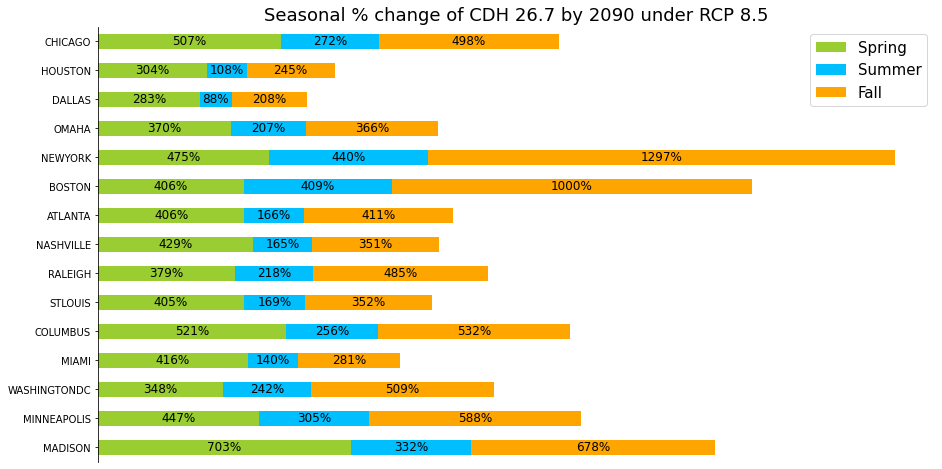

In [134]:
# when remove winter 
df = newdplot2_85.drop(['DJF_20_90'],axis=1)
colors = ['yellowgreen','deepskyblue','orange','darkgrey']


ax = df.plot.barh(figsize=(15,8),stacked=True,color=colors)
ax.legend(["Spring",'Summer','Fall'],fontsize=15)
ax.set_xticks([])

# ticks=np.arange(0,2400,400)
# ax.set_xticks(ticks)
# xlabel = [str(int(np.round(it,0)))+"%" for it in ticks]
# ax.set_xticklabels(xlabel,fontsize=14)

#remove frames
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)


# display values on the bars
for n in df: 
    for i, (cs, ab) in enumerate(zip(df.iloc[:, 0:].cumsum(1)[n],df[n])): 
        plt.text(cs-ab/2,i,str(int(ab))+'%',va='center',ha='center',color='black',fontsize=12)

plt.title('Seasonal % change of CDH 26.7 by 2090 under RCP 8.5',fontsize=18)
plt.savefig('results_plot/seasonalchange_cdh267_by2090_85.png',bbox_inches='tight')


In [ ]:
Newyork,Boston,Raleigh,Atlanta,Columbus,